Visualizing the 3D geometry of the X-ray detector in `DiffDRR` can be a helpful sanity check and is useful for debugging. We enable visualization of the `DiffDRR` setup using `PyVista`. The dependencies are `pyvista`, `trame`, and `vtk`.

The 3D visualization functions in `DiffDRR` perform the following steps:

- Extract a mesh from your CT volume
- Plot a pyramid frustum to visualize the camera pose
- Plot the detector plane with the DRR embedded as a texture
- Draw the principal ray from the X-ray source to the detector plane

We currently support the following backends for extracting meshes from CT scans:

- [MarchingCubes](https://docs.pyvista.org/version/stable/examples/01-filter/flying_edges.html#marching-cubes)
- [SurfaceNets](https://www.kitware.com/really-fast-isocontouring/)

In the future, we plan to merge [SurfaceNets](https://www.kitware.com/really-fast-isocontouring/) with [TotalSegmentator](https://github.com/wasserth/TotalSegmentator) such that CT meshes can be rendered from label maps.

In [ ]:
#| code-fold: true
import pyvista
import torch

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.pose import convert
from diffdrr.visualization import drr_to_mesh, img_to_mesh

pyvista.start_xvfb()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read in the volume and get the isocenter
volume, origin, spacing = load_example_ct()

# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr = DRR(volume, origin, spacing, sdd=1020.0, height=200, delx=2.0).to(device)

In [ ]:
# Make a mesh from the CT volume
ct = drr_to_mesh(drr, "surface_nets", threshold=225, verbose=False)

# Make a mesh from the camera and detector plane
rotations = torch.tensor([[0.0, torch.pi / 2, torch.pi / 2]], device=device)
translations = torch.tensor([[-10.0, 850.0, -175.0]], device=device)
pose = convert(
    rotations, translations, parameterization="euler_angles", convention="ZYX"
)
camera, detector, texture, principal_ray = img_to_mesh(drr, pose)

# # Make the plot
# plotter = pyvista.Plotter()
# plotter.add_mesh(ct)
# plotter.add_mesh(camera, show_edges=True, line_width=1.5)
# plotter.add_mesh(principal_ray, color="lime", line_width=3)
# plotter.add_mesh(detector, texture=texture)

# # Render the plot
# plotter.add_axes()
# plotter.add_bounding_box()

# # plotter.show()  # If running Jupyter locally
# # plotter.show(jupyter_backend="server")  # If running Jupyter remotely
# plotter.export_html("render.html")

In [ ]:
from IPython.display import IFrame

IFrame("render.html", height=500, width=749)

[<Axes: >]

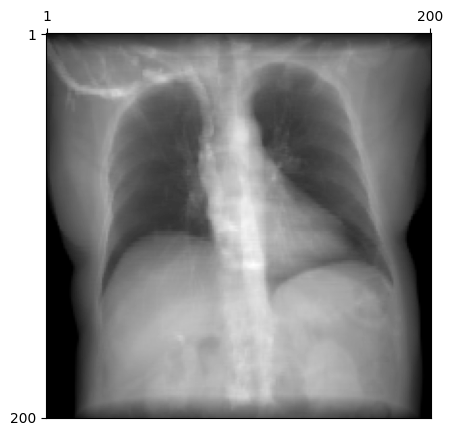

In [ ]:
from diffdrr.visualization import plot_drr

plot_drr(drr(pose))